In [1]:
import json

import mlflow
import pandas as pd
from lightgbm import LGBMRegressor
from mlem.api import build, save
from pandas_profiling import ProfileReport
from pycaret.regression import (
    compare_models,
    create_model,
    eda,
    evaluate_model,
    get_config,
    interpret_model,
    tune_model,
    plot_model,
    setup,
    set_config,
)
from pycaret.internal.preprocess.transformers import TransformerWrapper
from sklearn.compose import TransformedTargetRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.model_selection import cross_validate, KFold, train_test_split

***

### Config

In [2]:
# Some houskeeping stuff
mlflow.set_tracking_uri("http://mlflow:5000")
MODELS = ["lr", "lightgbm", "rf", "et", "dummy", "xgboost"]
SESSION_ID = 42

# Will use this dataframe to train a baseline model
raw_data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})

# This data will be used for training the candidate model(s).
data = pd.read_csv("house_prices.csv", dtype={"spaciousness": "int64"})
data = data.rename(columns={"sale_price": "target"})

### Examine pandas_profiling report

In [3]:
ProfileReport(raw_data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

***

### Raw dataset adjustments

By looking at the profile above, we can identify some irregularities with the dataset. In order to have a cleaner dataset, the folowing changes were made:

- Removed `has_pool` since it has constant 0 value
- Removed `liv_lot_ratio` as being binary does not match with the feature's description of being a ratio
- Removed negative `remodel_age` values
- Only `house_age` greater or equal to `garage_age`, assuming garage can not be older than the house

In [4]:
data = data.drop(columns=[
    "has_pool",
    "liv_lot_ratio",
])
data = data[data["remodel_age"] >= 0]
data = data[(data["house_age"] >= data["garage_age"]) | (data["garage_age"].isna())]
data.shape

(33011, 16)

***

### Baseline

Test multiple models with base dataset

In [5]:
setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
)
baseline = compare_models(include=MODELS)

***

### Custom preprocessing

Let's create a custom preprocessing pipeline and test it with the best previous model

In [6]:
categorical_columns = ["house_style", "neighborhood"]
numeric_columns = [
    "property_area",
    "house_age",
    "spaciousness",
    "remodel_age",
    "bath_area",
    "bsmt_area",
    "garage_area",
    "garage_age",
]
ordinal_columns = [
    "overall_quality",
    "overall_condition"
]
binary_columns = [
    "has_2ndfloor",
    "has_porch",
    "has_multiple_kitchen",
]

preprocessing = Pipeline([
    ("categorical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=categorical_columns)),
    ("numerical_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="mean"), include=numeric_columns)),
    ("ordinal_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="median"), include=ordinal_columns)),
    ("binary_imputer", TransformerWrapper(transformer=SimpleImputer(strategy="most_frequent"), include=binary_columns)),
    ("categorical_encoding", TransformerWrapper(transformer=OneHotEncoder(drop="first", handle_unknown="infrequent_if_exist"), include=categorical_columns)),
])

setup(
    data,
    session_id=SESSION_ID,
    target="target",
    log_experiment=True,
    transform_target=True,
    preprocess=False,
    custom_pipeline=preprocessing,
)

candidate = create_model("lightgbm")

***

### Tuning

Finally, let's fine tune the model to see if we can get even better performance

In [7]:
tuned = tune_model(candidate, search_library="optuna")

[I 2023-02-13 14:43:55,738] Searching the best hyperparameters using 23107 samples...


[LightGBM] [Warning] bagging_fraction is set=0.5814534893393928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5814534893393928
[LightGBM] [Warning] feature_fraction is set=0.7032221100071857, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7032221100071857
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.5806665380447127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5806665380447127
[LightGBM] [Warning] feature_fraction is set=0.882202503495937, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.882202503495937
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.9310817155527517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9310817155527517
[LightGBM] [Warning] feature_fraction

[I 2023-02-13 14:47:24,785] Finished hyperparemeter search!


### Model evaluation and explainability

In [8]:
evaluate_model(tuned)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

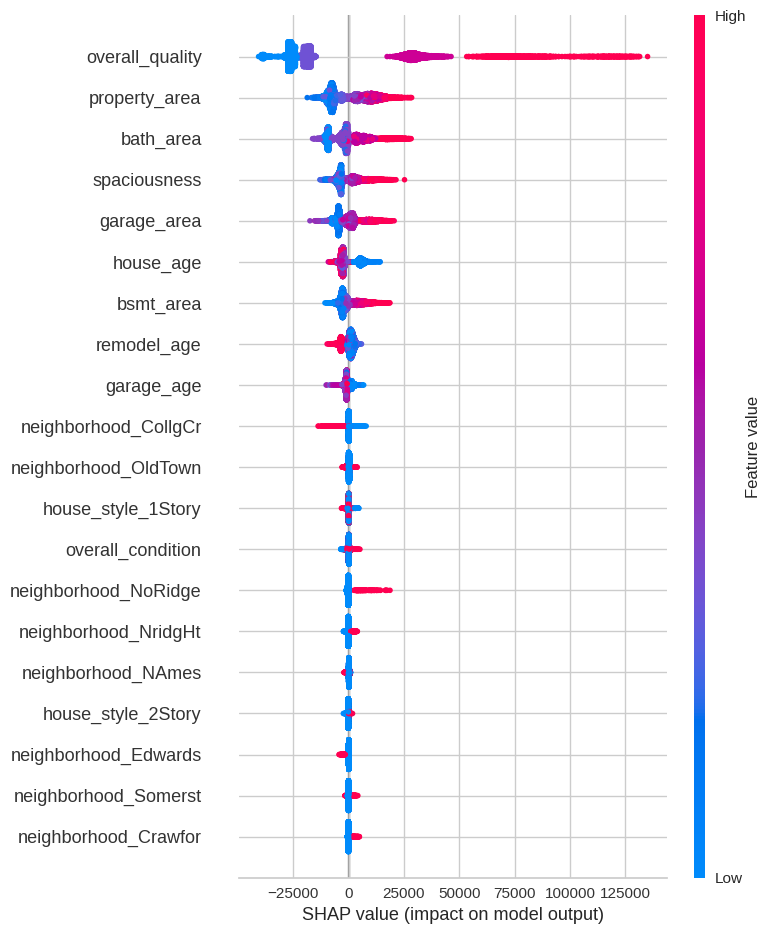

In [9]:
interpret_model(tuned)

### Train-test metrics

We first append the best performing model to the preprocessing pipeline.

In [10]:
preprocessing.steps.append(("estimator", tuned))

We will now fit the best model and get the train and test metrics

In [11]:
X = get_config("X")
y = get_config("y")

results = cross_validate(
    preprocessing,
    X,
    y,
    cv=KFold(n_splits=10, random_state=SESSION_ID, shuffle=True),
    return_train_score=True,
    scoring=[
        "neg_mean_absolute_error",
        "neg_mean_squared_error",
        "neg_root_mean_squared_error",
        "r2",
        "neg_mean_absolute_percentage_error",
    ]
)

[LightGBM] [Warning] bagging_fraction is set=0.7527038754066129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527038754066129
[LightGBM] [Warning] feature_fraction is set=0.8472422639049875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472422639049875
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7527038754066129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527038754066129
[LightGBM] [Warning] feature_fraction is set=0.8472422639049875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472422639049875
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.7527038754066129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527038754066129
[LightGBM] [Warning] feature_fracti

Generate a DataFrame for easy access to the results

In [12]:
results = pd.DataFrame(results)
results = pd.concat([results, results.mean().to_frame(name="mean").T])
results = pd.concat([results, results.std().to_frame(name="std").T])
results

fit_time  score_time  test_neg_mean_absolute_error  \
0     1.868291    0.038174                 -25537.932059   
1     1.606419    0.030499                 -25174.688689   
2     1.682263    0.041960                 -25065.105512   
3     1.198880    0.042394                 -25075.914382   
4     0.884944    0.037614                 -25195.420471   
5     1.385220    0.054875                 -25262.788602   
6     1.092595    0.062264                 -24651.677184   
7     1.248883    0.046950                 -25276.285224   
8     1.115750    0.027241                 -24817.198569   
9     1.379579    0.042774                 -24619.179605   
mean  1.346283    0.042475                 -25067.619030   
std   0.285871    0.009916                    277.040662   

      train_neg_mean_absolute_error  test_neg_mean_squared_error  \
0                     -23245.713205                -1.147564e+09   
1                     -23286.990279                -1.135264e+09   
2                     -23300.612579                -1.131511e+09   
3                     -23276.761073                -1.139945e+09   
4                     -23279.691028                -1.168283e+09   
5                     -23291.111027                -1.164641e+09   
6                     -23366.305576                -1.116350e+09   
7                     -23261.372784                -1.210881e+09   
8                     -23284.878189                -1.087556e+09   
9                     -23359.150834                -1.111241e+09   
mean                  -23295.258658                -1.141324e+09   
std                       36.795894                 3.271401e+07   

      train_neg_mean_squared_error  test_neg_root_mean_squared_error  \
0                    -9.514957e+08                     -33875.715033   
1                    -9.520943e+08                     -33693.678713   
2                    -9.530176e+08                     -33637.942784   
3                    -9.515568e+08                     -33763.065596   
4                    -9.484194e+08                     -34180.157104   
5                    -9.492932e+08                     -34126.830681   
6                    -9.553534e+08                     -33411.829909   
7                    -9.460505e+08                     -34797.709203   
8                    -9.551335e+08                     -32978.118103   
9                    -9.548951e+08                     -33335.282956   
mean                 -9.517309e+08                     -33780.033008   
std                   2.928504e+06                        482.655782   

      train_neg_root_mean_squared_error   test_r2  train_r2  \
0                         -30846.323554  0.759481  0.795341   
1                         -30856.025523  0.757085  0.795718   
2                         -30870.982715  0.758159  0.795494   
3                         -30847.314100  0.766492  0.794814   
4                         -30796.417856  0.749130  0.796584   
5                         -30810.601747  0.757939  0.795637   
6                         -30908.791415  0.744529  0.796491   
7                         -30757.933994  0.742724  0.796848   
8                         -30905.234428  0.763645  0.795417   
9                         -30901.376994  0.750563  0.796177   
mean                      -30850.100233  0.754975  0.795852   
std                           47.479993  0.007512  0.000613   

      test_neg_mean_absolute_percentage_error  \
0                                   -0.152684   
1                                   -0.155237   
2                                   -0.155568   
3                                   -0.152528   
4                                   -0.154132   
5                                   -0.151930   
6                                   -0.151360   
7                                   -0.153165   
8                                   -0.150859   
9                                   -0.149689   
mean                                -0.15271

Generate a model summary

In [13]:
usi = get_config("USI")
model_summary = {
    "features": X.columns.tolist(),
    "artifact": {
        "model": "lightgbm",
        "usi": usi,
    },
    "cv": {
        "folds": 10,
        "random_state": SESSION_ID,
        "strategy": "KFold",
    },
    "train": {
        "r2": {
            "mean": results.loc["mean", "train_r2"],
            "std": results.loc["std", "train_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "train_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "train_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "train_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "train_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "train_neg_root_mean_squared_error"],
        },
    },
    "test": {
        "r2": {
            "mean": results.loc["mean", "test_r2"],
            "std": results.loc["std", "test_r2"],
        },
        "mae": {
            "mean": results.loc["mean", "test_neg_mean_absolute_error"] * -1,
            "std": results.loc["std", "test_neg_mean_absolute_error"],
        },
        "mse": {
            "mean": results.loc["mean", "test_neg_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_mean_squared_error"],
        },
        "rmse": {
            "mean": results.loc["mean", "test_neg_root_mean_squared_error"] * -1,
            "std": results.loc["std", "test_neg_root_mean_squared_error"],
        },
    },
}

And fit the model with all the data

In [14]:
preprocessing.fit(X, y)

[LightGBM] [Warning] bagging_fraction is set=0.7527038754066129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7527038754066129
[LightGBM] [Warning] feature_fraction is set=0.8472422639049875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8472422639049875
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


Pipeline(steps=[('categorical_imputer',
                 TransformerWrapper(include=['house_style', 'neighborhood'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('numerical_imputer',
                 TransformerWrapper(include=['property_area', 'house_age',
                                             'spaciousness', 'remodel_age',
                                             'bath_area', 'bsmt_area',
                                             'garage_area', 'garage_age'],
                                    transformer=SimpleImputer())),
                ('ordinal_i...
                                                              handle_unknown='infrequent_if_exist'))),
                ('estimator',
                 LGBMRegressor(bagging_fraction=0.7527038754066129,
                               bagging_freq=2,
                               feature_fraction=0.8472422639049875,
                               learning_rate=0.02924321244515797,
                               min_child_samples=24,
                               min_split_gain=0.5750393854640294,
                               n_estimators=152, num_leaves=74, random_state=42,
                               reg_alpha=5.890917886797251e-08,
                               reg_lambda=2.7799765057343166e-09))])

### Serialization

Finally, we save the artifact

In [15]:
save(preprocessing, f"models/{usi}_model")

MlemModel(location=Location(path='/app/models/7f86_model.mlem', project=None, rev=None, uri='file:///app/models/7f86_model.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0xffff3030f760>), params={}, artifacts={'data': LocalArtifact(uri='7f86_model', size=998348, hash='e1a2fb371ee16280581198c1b2183250')}, requirements=Requirements(__root__=[InstallableRequirement(module='sklearn', version='1.2.1', package_name='scikit-learn', extra_index=None), UnixPackageRequirement(package_name='libgomp1'), InstallableRequirement(module='lightgbm', version='3.3.5', package_name=None, extra_index=None), InstallableRequirement(module='pycaret', version='3.0.0.rc9', package_name=None, extra_index=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('categorical_imputer',
                 TransformerWrapper(include=['house_style', 'neighborhood'],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
      

The model summary

In [16]:
with open(f"models/{usi}_summary.json", "w+") as f:
    json.dump(model_summary, f)

And the model's requirements

In [17]:
build("requirements", f"models/{usi}_model", target=f"models/{usi}_requirements.txt")